<a href="https://www.kaggle.com/rsizem2/kaggle-learn-reference-feature-engineering?scriptVersionId=84622061" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Feature Engineering

This notebook is an attempt to summarize the feature engineering techniques covered in the [Kaggle Learn](https://www.kaggle.com/learn/feature-engineering) course (the notes, the exercises and the [bonus notebook](https://www.kaggle.com/ryanholbrook/feature-engineering-for-house-prices)) into one notebook for easier reference. We conclude with a sample competition submission to the [Housing Prices Competition for Kaggle Learn Users](https://www.kaggle.com/c/home-data-for-ml-course).

In [1]:
# Global variables for testing changes to this notebook quickly
RANDOM_SEED = 0
NUM_FOLDS = 12
MAX_TREES = 2000
EARLY_STOP = 50
NUM_TRIALS = 5
SUBMIT = True

## Imports

In [2]:
# Essentials
import os
import warnings
import numpy as np
import pandas as pd
import time
from collections import defaultdict

# Models
from sklearn.base import clone
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Model Evaluation
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_absolute_error

# Preprocessing
from functools import partial, reduce
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder, OneHotEncoder

# Feature Engineering
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from category_encoders import MEstimateEncoder

# Hyperparameter Tuning
import optuna
from optuna.visualization import plot_param_importances, plot_parallel_coordinate
from optuna.pruners import PercentilePruner

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
warnings.filterwarnings('ignore')

## Load Data

We bin the target variable `SalePrice` for the sake of cross-validation, we want each fold to have a similar target distribution to the overall training data.

In [3]:
# Load the training data
train = pd.read_csv("../input/home-data-for-ml-course/train.csv")
test = pd.read_csv("../input/home-data-for-ml-course/test.csv")

# Remove rows with missing target
train.dropna(axis=0, subset=['SalePrice'], inplace=True)

# Columns of interest
features = [x for x in train.columns if x not in ['SalePrice','Id']]
categorical = [x for x in features if train[x].dtype == "object"]
numerical = [x for x in features if  train[x].dtype in ['int64', 'float64']]

# Bin target for stratified cross-validation
binner = KBinsDiscretizer(n_bins = 45, encode = 'ordinal', strategy = 'quantile')
y_bins = binner.fit_transform(pd.DataFrame(data=train['SalePrice']))

# Preliminaries: Preprocessing 

This section involves preprocessing our data prior to feature engineering, in particular, dealing with missing values and encoding categorical variables. This content is covered in the [Intermediate Machine Learning](https://www.kaggle.com/learn/intermediate-machine-learning) course, and is the subject of my [previous notebook](https://www.kaggle.com/rsizem2/kaggle-learn-reference-intermediate-ml). In this section we will do the following:

1. Clean data by fixing typos and erroneous values
2. Impute numerical data with the column mean
3. Ordinally encode the *ordinal* variables
4. Use a mix of ordinal and one-hot encoding for the *nominal* variables

## 1. Data Cleaning

In [4]:
def data_cleaning(input_df):
    df = input_df.copy()
    
    # Data cleaning: fix typos and bad values
    df['MSZoning'] =  df['MSZoning'].replace({'C (all)': 'C'})
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn":"BrkComm","Wd Shng": "WdShing"})
    df['Neighborhood'] = df['Neighborhood'].replace({'NAmes':'Names'})
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    #df["MSClass"] = df['MSZoning'].map({'A': 'A','C': 'C',"FV": 'R','I': 'I',"RH": 'R',"RL": 'R',"RP": 'R',"RM": 'R', np.nan:np.nan})
    
    return df

## 2. Imputation

In [5]:
# Transformations that depend only on the input data (no fear of leakage)
def imputation(X_train, X_valid, X_test = None, num_strategy = 'mean', cat_strategy = 'constant'):

    X_train, X_valid = X_train.copy(), X_valid.copy()
    if X_test is not None: 
        X_test = X_test.copy()
    
    # 1. impute numerical data
    assert num_strategy in ['median','mean']
    columns = [col for col in X_train.columns if X_train[col].dtype != "object"]
    num_imputer = SimpleImputer(strategy = num_strategy)
    X_train[columns] = num_imputer.fit_transform(X_train[columns])
    X_valid[columns] = num_imputer.transform(X_valid[columns])
    if X_test is not None:
        X_test[columns] = num_imputer.transform(X_test[columns])
    
    # 2. impute categorical data
    assert cat_strategy in ['constant','most_frequent']
    cat_imputer = SimpleImputer(strategy = cat_strategy, fill_value = 'None')
    columns = [col for col in X_train.columns if X_train[col].dtype == "object"]
    X_train[columns] = cat_imputer.fit_transform(X_train[columns])
    X_valid[columns] = cat_imputer.transform(X_valid[columns])
    if X_test is not None:
        X_test[columns] = cat_imputer.transform(X_test[columns])
        
    return X_train, X_valid, X_test

## 3. Encoding Ordinal Variables

Up to this point we have been encoding our categorical data arbitrarily. However a lot of the data has a natural ordering as it represents grading or rating (poor, fair, good, etc.) of various qualities of the property. We hard-code this ordering using ordinal encoding and specifying the exact ordering the data should have.

In [6]:
def ordinal_encoding(X_train, X_valid, X_test = None):
    
    X_train, X_valid = X_train.copy(), X_valid.copy()
    if X_test is not None: 
        X_test = X_test.copy()
    
    # 1. Encode 1-10 ratings
    cols = ["OverallQual","OverallCond"]
    cols = [x for x in cols if x in X_train.columns]
    ratings = {float(a):b for b,a in enumerate(range(1,11))}
    mapping = [{'col':x, 'mapping': ratings} for x in cols]
    
    encoder = OrdinalEncoder(cols = cols, mapping = mapping, handle_missing = 'return_nan')
    X_train = encoder.fit_transform(X_train)
    X_valid = encoder.transform(X_valid)
    if X_test is not None: 
        X_test = encoder.transform(X_test)
    
    # 2. Encode Poor, Fair, Avg, Good, Ex ratings
    cols = ["ExterQual","ExterCond","BsmtQual","BsmtCond","HeatingQC", "KitchenQual","FireplaceQu","GarageQual","GarageCond",'PoolQC']
    cols = [x for x in cols if x in X_train.columns]
    ratings = {"Po":0, "Fa":1, "TA":2, "Gd":3, "Ex":4}
    mapping = [{'col':x, 'mapping': ratings} for x in cols]
    
    encoder = OrdinalEncoder(cols = cols, mapping = mapping, handle_missing = 'return_nan')
    X_train = encoder.fit_transform(X_train)
    X_valid = encoder.transform(X_valid)
    if X_test is not None: 
        X_test = encoder.transform(X_test)
    
    # 3. Encode remaining ordinal data
    cols = ["LotShape","LandSlope","BsmtExposure","BsmtFinType1","BsmtFinType2",
    "Functional","GarageFinish","PavedDrive","Utilities","CentralAir","Electrical",
    "Fence"]
    cols = [x for x in cols if x in X_train.columns]
    mapping = [{'col':"LotShape",
                'mapping': {"Reg":0, "IR1":1, "IR2":2, "IR3":3}},
               {'col':"LandSlope",
                'mapping': {"Sev":0, "Mod":1, "Gtl":2}},
               {'col':"BsmtExposure",
                'mapping': {"No":0, "Mn":1, "Av":2, "Gd":3}},
               {'col':"BsmtFinType1",
                'mapping': {"Unf":0, "LwQ":1, "Rec":2, "BLQ":3, "ALQ":4, "GLQ":5}},
               {'col':"BsmtFinType2",
                'mapping': {"Unf":0, "LwQ":1, "Rec":2, "BLQ":3, "ALQ":4, "GLQ":5}},
               {'col':"Functional",
                'mapping': {"Sal":0, "Sev":1, "Maj1":2, "Maj2":3, "Mod":4, "Min2":5, "Min1":6, "Typ":7}},
               {'col':"GarageFinish",
                'mapping': {"Unf":0, "RFn":1, "Fin":2}},
               {'col':"PavedDrive",
                'mapping': {"N":0, "P":1, "Y":2}},
               {'col':"Utilities",
                'mapping': {"NoSeWa":0, "NoSewr":1, "AllPub":2}},
               {'col':"CentralAir",
                'mapping': {"N":0, "Y":1}},
               {'col':"Electrical",
                'mapping': {"Mix":0, "FuseP":1, "FuseF":2, "FuseA":3, "SBrkr":4}},
               {'col':"Fence",
                'mapping': {"MnWw":0, "GdWo":1, "MnPrv":2, "GdPrv":3}}]
    mapping = [x for x in mapping if x['col'] in X_train.columns]
    
    encoder = OrdinalEncoder(cols = cols, mapping = mapping, handle_missing = 'return_nan')
    X_train = encoder.fit_transform(X_train)
    X_valid = encoder.transform(X_valid)
    if X_test is not None: 
        X_test = encoder.transform(X_test)
        
    return X_train, X_valid, X_test

## 4. Encoding Nominal Data

The remaining data has no natural ordering, so we one-hot encode low cardinality nominal data and ordinally encode high cardinality nominal data. Recall the *cardinality* refers to the number of unique values.

In [7]:
# Not ordinal categorical data
#columns = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", 
#           "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", 
#           "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", 
#           "Heating", "CentralAir", "GarageType", "MiscFeature", "SaleType", "SaleCondition"]

def nominal_encoding(X_train, X_valid, X_test = None, threshold = 10):
    
    X_train, X_valid = X_train.copy(), X_valid.copy()
    if X_test is not None: 
        X_test = X_test.copy()
    
    # 1. Determine high and low cardinality data
    columns = [col for col in X_train.columns if X_train[col].dtype == 'object']
    high_cols = [col for col in columns if X_train[col].nunique() >= threshold]
    low_cols = [col for col in columns if X_train[col].nunique() < threshold]
    
    # label encode high cardinality data
    if high_cols:
        encoder = OrdinalEncoder(cols = high_cols, handle_missing = 'return_nan')
        X_train = encoder.fit_transform(X_train)
        X_valid = encoder.transform(X_valid)
        if X_test is not None: 
            X_test = encoder.transform(X_test)
    
    if low_cols:
        encoder = OneHotEncoder(cols = low_cols, use_cat_names = True, handle_missing = 'return_nan')
        X_train = encoder.fit_transform(X_train)
        X_valid = encoder.transform(X_valid)
        if X_test is not None: 
            X_test = encoder.transform(X_test)
        
    return X_train, X_valid, X_test

## Full Preprocessing 

In [8]:
def preprocessing(X_train, X_valid, X_test = None):
    
    # 1. Data cleaning
    X_train = data_cleaning(X_train)
    X_valid = data_cleaning(X_valid)
    if X_test is not None: 
        X_test = data_cleaning(X_test)
        
    # 2. Imputation
    X_train, X_valid, X_test = imputation(X_train, X_valid, X_test)
        
    # 3. Ordinal Encoding
    X_train, X_valid, X_test = ordinal_encoding(X_train, X_valid, X_test)
    
    # 4. Nominal Encoding
    X_train, X_valid, X_test = nominal_encoding(X_train, X_valid, X_test)
        
    return X_train, X_valid, X_test

# Feature Engineering

In this section we consider the feature engineering techniques covered in the course and benchmark them against a baseline consisting of only the preprocessing.

## 1. Scoring Function

We create a function which takes a preprocessing (feature engineering) function and scores it using cross-validation and returns the mean absolute error (MAE).

In [9]:
def score_xgboost(xgb_model = XGBRegressor(random_state = RANDOM_SEED, n_estimators = 500, learning_rate = 0.05), processing = preprocessing, trial = None, verbose = True):
    
    # Drop high cardinality categorical variables
    features = [x for x in train.columns if x not in ['Id','SalePrice']]
    X_temp = train[features].copy()
    y_temp = train['SalePrice'].copy()
    
    # Data structure for storing scores and times
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    
    # Stratified k-fold cross-validation
    kfold = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(kfold.split(X_temp, y_bins)):
        
        # Training and Validation Sets
        X_train, X_valid = X_temp.iloc[train_idx], X_temp.iloc[valid_idx]
        y_train, y_valid = y_temp.iloc[train_idx], y_temp.iloc[valid_idx]
        
        # Preprocessing
        X_train, X_valid, _ = processing(X_train, X_valid)
        
        # Create model
        start = time.time()
        model = clone(xgb_model)
        model.fit(
            X_train, y_train, 
            early_stopping_rounds=EARLY_STOP,
            eval_set=[(X_valid, y_valid)], 
            verbose=False
        )
        
        # validation predictions
        valid_preds = np.ravel(model.predict(X_valid))
        scores[fold] = mean_absolute_error(y_valid, valid_preds)
        end = time.time()
        if verbose: print(f'Fold {fold} MAE: {round(scores[fold], 5)} in {round(end-start,2)}s.')
        time.sleep(0.5)
        
        if trial:
            # Use pruning on fold AUC
            trial.report(
                value = scores[fold],
                step = fold
            )
            # prune slow trials and bad fold AUCs
            if trial.should_prune():
                raise optuna.TrialPruned()
    
    return scores.mean()

## 2. XGBoost Baseline

In [10]:
# Data structure for saving our training scores
benchmarks = defaultdict(list)

# Baseline score
score = score_xgboost()

# Save scores
benchmarks['feature'].append('Baseline')
benchmarks['score'].append(score)

Fold 0 MAE: 19664.31141 in 0.8s.
Fold 1 MAE: 13970.71747 in 4.21s.
Fold 2 MAE: 15982.84106 in 1.93s.
Fold 3 MAE: 15983.99689 in 3.06s.
Fold 4 MAE: 15745.98745 in 2.55s.
Fold 5 MAE: 17797.8003 in 3.42s.
Fold 6 MAE: 16379.00916 in 2.27s.
Fold 7 MAE: 13614.71574 in 3.55s.
Fold 8 MAE: 13944.10269 in 2.52s.
Fold 9 MAE: 17565.67943 in 1.15s.
Fold 10 MAE: 15910.51317 in 2.62s.
Fold 11 MAE: 13501.98906 in 3.43s.


# Lesson 2: Mutual Information

Discard uninformative features, as determined by having zero mutual information.

## 2.1 Most Informative Features

In [11]:
def get_mi_scores():
    
    # Preprocessing
    columns = [x for x in train.columns if x not in ['Id','SalePrice']]
    X_train, X_test, _ = preprocessing(train[columns], test[columns])
    discrete = [i for i,x in enumerate(X_train.columns) if x not in numerical]
    y_train = train['SalePrice']
    
    # Get Score
    scores = mutual_info_regression(
        X_train, y_train, discrete_features = discrete
    )
    scores = pd.Series(scores, name = "MI Scores", index = X_train.columns)
    return scores.sort_values(ascending=False)

In [12]:
# Get sorted list of features
get_mi_scores()

OverallQual           0.563482
Neighborhood          0.529628
GrLivArea             0.482960
GarageCars            0.368718
YearBuilt             0.368601
                        ...   
MiscFeature_None      0.000000
PoolQC                0.000000
PoolArea              0.000000
RoofMatl_Tar&Grv      0.000000
GarageType_Basment    0.000000
Name: MI Scores, Length: 185, dtype: float64

## 2.2 Plot Informative Features

In [13]:
def plot_informative(threshold = 0.1):
    scores = get_mi_scores()
    scores.drop(scores[scores <= threshold].index, inplace = True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.figure(dpi=100, figsize=(8,6))
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

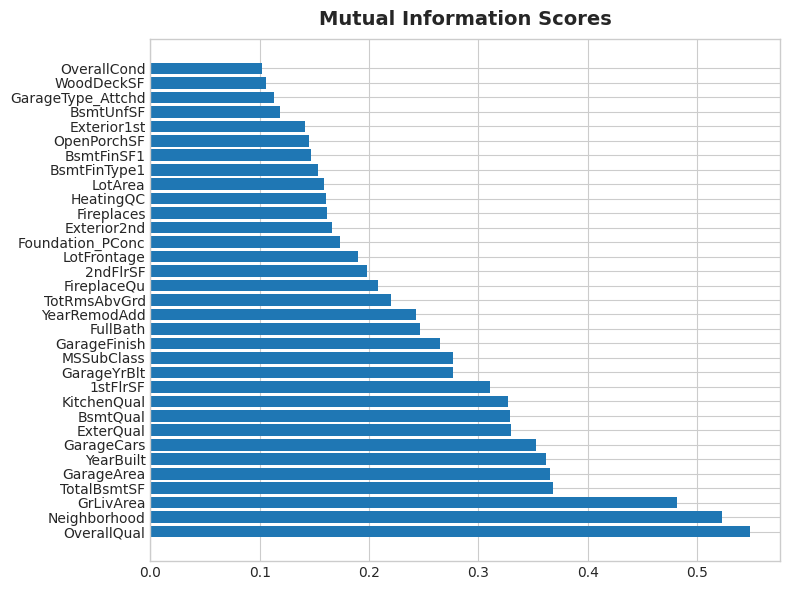

In [14]:
plot_informative()

## 2.3 Drop Uninformative Features

Preprocessing step which removes features with a mutual information score below a given threshold

In [15]:
# X_train must have no NA values
def remove_uninformative(X_train, X_valid, X_test = None, threshold = 1e-5, verbose = False):
    
    # 0. Preprocessing
    X_train, X_valid, X_test = preprocessing(X_train, X_valid, X_test)
    
    # 1. Get discrete columns and target
    discrete = [i for i,x in enumerate(X_train.columns) if x not in numerical]
    y_train = train['SalePrice'].iloc[X_train.index]
    
    # 2. Get mutual information scores
    scores = mutual_info_regression(X_train, y_train, discrete_features = discrete)
    cols = [x for i, x in enumerate(X_train.columns) if scores[i] < threshold]
    
    # 3. Drop the uninformative columns
    X_train.drop(cols, axis = 1, inplace = True)
    X_valid.drop(cols, axis = 1, inplace = True)
    if X_test is not None: X_test.drop(cols, axis = 1, inplace = True)
    
    if verbose:
        print("Dropped columns:", *cols)
    
    return X_train, X_valid, X_test

In [16]:
# Drop uninformative
score = score_xgboost(processing = remove_uninformative)

# Save scores
benchmarks['feature'].append('Mutual_Info')
benchmarks['score'].append(score)

Fold 0 MAE: 19536.05347 in 0.66s.
Fold 1 MAE: 13873.74616 in 2.81s.
Fold 2 MAE: 15949.47118 in 1.43s.
Fold 3 MAE: 15722.44128 in 1.61s.
Fold 4 MAE: 15578.00864 in 2.14s.
Fold 5 MAE: 17645.18744 in 2.76s.
Fold 6 MAE: 16232.66323 in 2.0s.
Fold 7 MAE: 13487.94499 in 1.48s.
Fold 8 MAE: 14002.06095 in 2.2s.
Fold 9 MAE: 17395.23357 in 1.03s.
Fold 10 MAE: 15170.77395 in 2.34s.
Fold 11 MAE: 13333.77044 in 2.24s.


# Lesson 3: Creating Features

In this section we consider transformations of existing features:

1. Mathematical Transformations
2. Feature Interactions
3. Count Features
4. Building and breaking down features
5. Group transformations


## 3.1 Mathematical Transformations

Create features by combining and/or transforming already existing features

In [17]:
def transformations(input_df, test_data = False):
    
    df = input_df.copy()
    temp = train.iloc[df.index]
    if test_data: temp = test.copy()
        
    df["LivLotRatio"] = temp["GrLivArea"]/ temp["LotArea"]
    df["Spaciousness"] = (temp["1stFlrSF"]+temp["2ndFlrSF"]) / temp["TotRmsAbvGrd"]
    df["TotalOutsideSF"] = temp["WoodDeckSF"] + temp["OpenPorchSF"] + temp["EnclosedPorch"] + temp["3SsnPorch"] + temp["ScreenPorch"]
    df['TotalLot'] = temp['LotFrontage'] + temp['LotArea']
    df['TotalBsmtFin'] = temp['BsmtFinSF1'] + temp['BsmtFinSF2']
    df['TotalSF'] = temp['TotalBsmtSF'] + temp['2ndFlrSF'] + temp['1stFlrSF']
    df['TotalBath'] = temp['FullBath'] + temp['HalfBath'] * 0.5 + temp['BsmtFullBath'] + temp['BsmtHalfBath'] * 0.5
    df['TotalPorch'] = temp['OpenPorchSF'] + temp['EnclosedPorch'] + temp['ScreenPorch'] + temp['WoodDeckSF']
    
    return df
    
def mathematical_transformations(X_train, X_valid, X_test = None):
    
    # 0. Preprocessing
    X_train, X_valid, X_test = preprocessing(X_train, X_valid, X_test)
    
    X_train = transformations(X_train)
    X_valid = transformations(X_valid)
    if X_test is not None: X_test = transformations(X_test)
    
    return X_train, X_valid, X_test

In [18]:
# Mathematical transformations
score = score_xgboost(processing = mathematical_transformations)

# Save scores
benchmarks['feature'].append('Transformations')
benchmarks['score'].append(score)

Fold 0 MAE: 18165.85553 in 1.03s.
Fold 1 MAE: 11942.10272 in 4.85s.
Fold 2 MAE: 16858.15055 in 1.7s.
Fold 3 MAE: 14492.51777 in 3.06s.
Fold 4 MAE: 15424.427 in 1.89s.
Fold 5 MAE: 16765.02955 in 3.04s.
Fold 6 MAE: 16905.57153 in 1.92s.
Fold 7 MAE: 14045.00058 in 2.32s.
Fold 8 MAE: 15278.25365 in 3.97s.
Fold 9 MAE: 16746.39276 in 2.89s.
Fold 10 MAE: 14294.36021 in 1.77s.
Fold 11 MAE: 15187.75998 in 2.14s.


## 3.2 Encode Feature Interactions

Attempt to encode an interaction between a categorical variable and a numerical variable

In [19]:
def interaction(input_df, cat_col = "BldgType", num_col = "GrLivArea"):
    
    df = input_df.copy()
    try:
        X = pd.get_dummies(df[cat_col], prefix=cat_col)
        for col in X.columns:
            df[col+"_"+num_col] = X[col]*df[num_col]
    except:
        for col in df.columns:
            if col.startswith(cat_col):
                df[col+"_"+num_col] = df[col]*df[num_col]
    return df

def encode_interaction(X_train, X_valid, X_test = None, cat_col = "BldgType", num_col = "GrLivArea"):
    
    X_train, X_valid, X_test = preprocessing(X_train, X_valid, X_test)

    X_train = interaction(X_train, cat_col, num_col)
    X_valid = interaction(X_valid, cat_col, num_col)
    if X_test is not None: X_test = interaction(X_test, cat_col, num_col)
    
    return X_train, X_valid, X_test

In [20]:
# Categorical interactions
score = score_xgboost(processing = encode_interaction)

# Save scores
benchmarks['feature'].append('Interactions')
benchmarks['score'].append(score)

Fold 0 MAE: 19803.18315 in 0.82s.
Fold 1 MAE: 14266.14005 in 2.11s.
Fold 2 MAE: 16192.22592 in 3.81s.
Fold 3 MAE: 16617.16076 in 2.78s.
Fold 4 MAE: 15622.28023 in 2.45s.
Fold 5 MAE: 16872.12404 in 4.48s.
Fold 6 MAE: 16396.64069 in 3.15s.
Fold 7 MAE: 13410.07729 in 2.58s.
Fold 8 MAE: 13755.12297 in 2.42s.
Fold 9 MAE: 17311.10376 in 1.82s.
Fold 10 MAE: 16068.81185 in 2.01s.
Fold 11 MAE: 13927.99593 in 3.55s.


## 3.3 Generate a Count Feature

We combine several related features into an aggregate feature counting the presence of the components.

In [21]:
def count_features(X_train, X_valid, X_test = None, features = ["WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch"]):
    
    X_train, X_valid, X_test = preprocessing(X_train, X_valid, X_test)
    
    X_train["PorchTypes"] = X_train[features].gt(0).sum(axis=1)
    X_valid["PorchTypes"] = X_valid[features].gt(0).sum(axis=1)
    if X_test is not None: X_test["PorchTypes"] = X_test[features].gt(0).sum(axis=1)
        
    return X_train, X_valid, X_test

In [22]:
# New count features
score = score_xgboost(processing = count_features)

# Save scores
benchmarks['feature'].append('Count')
benchmarks['score'].append(score)

Fold 0 MAE: 18975.37538 in 0.82s.
Fold 1 MAE: 13342.89613 in 4.3s.
Fold 2 MAE: 15965.47784 in 2.62s.
Fold 3 MAE: 15953.27808 in 2.83s.
Fold 4 MAE: 15835.69679 in 1.89s.
Fold 5 MAE: 18116.0228 in 3.45s.
Fold 6 MAE: 16444.10566 in 2.56s.
Fold 7 MAE: 13343.38115 in 3.14s.
Fold 8 MAE: 14013.80294 in 3.13s.
Fold 9 MAE: 17398.74174 in 2.3s.
Fold 10 MAE: 16354.96455 in 1.08s.
Fold 11 MAE: 13328.12946 in 3.18s.


## 3.4 Break Down a Categorical Feature

Note: The column `HouseStyle` already serves the purpose of the `MSClass` feature in the notes, so we create `MSClass` use the `Zoning` column instead. For simplicity, we created this feature during the data cleaning step.

In [23]:
def breakdown_zoning(X_train, X_valid, X_test = None):
    
    mapping = {'A': 'A','C': 'C',"FV": 'R','I': 'I',"RH": 'R',"RL": 'R',"RP": 'R',"RM": 'R', np.nan:np.nan}
    
    X_train["MSClass"] = train['MSZoning'].iloc[X_train.index].map(mapping)
    X_valid["MSClass"] = train['MSZoning'].iloc[X_valid.index].map(mapping)
    if X_test is not None: X_test["MSClass"] = test['MSZoning'].map(mapping)
    
    X_train, X_valid, X_test = preprocessing(X_train, X_valid, X_test)
    
    return X_train, X_valid, X_test

In [24]:
# New count features
score = score_xgboost(processing = breakdown_zoning)

# Save scores
benchmarks['feature'].append('MSZoning')
benchmarks['score'].append(score)

Fold 0 MAE: 19664.31141 in 0.81s.
Fold 1 MAE: 13970.71747 in 3.38s.
Fold 2 MAE: 15982.84106 in 2.09s.
Fold 3 MAE: 15983.99689 in 3.13s.
Fold 4 MAE: 15745.98745 in 2.6s.
Fold 5 MAE: 17797.8003 in 4.43s.
Fold 6 MAE: 16379.00916 in 2.31s.
Fold 7 MAE: 13614.71574 in 3.71s.
Fold 8 MAE: 13944.10269 in 2.56s.
Fold 9 MAE: 17565.67943 in 1.16s.
Fold 10 MAE: 15910.51317 in 2.64s.
Fold 11 MAE: 13501.98906 in 3.49s.


## 3.5 Use a Grouped Transform

We create a feature from a statistic calculated on a group. In this case the above ground living area per neighborhood. Note that the statistic is calculated on the training data only.

In [25]:
def group_transformation(X_train, X_valid, X_test = None):
    
    X_train, X_valid, X_test = preprocessing(X_train, X_valid, X_test)
    X_train["MedNhbdLvArea"] = X_train.groupby("Neighborhood")["GrLivArea"].transform('median')
    
    # we use the medians from the training data to impute the test data
    mapping = {y:x for x,y in zip(X_train["MedNhbdLvArea"].values, X_train['Neighborhood'].values)}
    
    X_valid["MedNhbdLvArea"] = X_valid['Neighborhood'].map(mapping)
    if X_test is not None: X_test["MedNhbdLvArea"] = X_test['Neighborhood'].map(mapping)
    
    return X_train, X_valid, X_test

In [26]:
# New count features
score = score_xgboost(processing = group_transformation)

# Save scores
benchmarks['feature'].append('Group')
benchmarks['score'].append(score)

Fold 0 MAE: 19107.43519 in 0.83s.
Fold 1 MAE: 13068.80264 in 3.0s.
Fold 2 MAE: 16870.48546 in 1.73s.
Fold 3 MAE: 14946.65106 in 3.24s.
Fold 4 MAE: 14222.44743 in 2.33s.
Fold 5 MAE: 16087.133 in 3.33s.
Fold 6 MAE: 16462.08831 in 2.91s.
Fold 7 MAE: 14684.6907 in 1.49s.
Fold 8 MAE: 13856.25287 in 3.49s.
Fold 9 MAE: 16734.12219 in 2.12s.
Fold 10 MAE: 15934.50323 in 1.56s.
Fold 11 MAE: 14304.39824 in 3.23s.


# Lesson 4: K-means Clustering

In this section we use unsupervised clustering techniques to build new features for our model.

## 4.1 Cluster Label Features

We create a new feature by clustering a subset of the numerical data and using the resulting cluster labels to create a new categorical feature.

In [27]:
def cluster_labels(X_train, X_valid, X_test = None, name = "Area", features = ['LotArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF','GrLivArea']):
    
    X_train, X_valid, X_test = preprocessing(X_train, X_valid, X_test)
    
    # 1. normalize based on training data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train[features])
    X_valid_scaled = scaler.transform(X_valid[features])
    if X_test is not None: X_test_scaled = scaler.transform(X_test[features])
    
    # 2. create cluster labels (use predict)
    kmeans = KMeans(n_clusters = 10, n_init = 10, random_state=0)
    X_train[name + "_Cluster"] = kmeans.fit_predict(X_scaled)
    X_valid[name + "_Cluster"] = kmeans.predict(X_valid_scaled)
    if X_test is not None: X_test[name + "_Cluster"] = kmeans.predict(X_test_scaled)
         
    return X_train, X_valid, X_test

In [28]:
# Cluster label features
score = score_xgboost(processing = cluster_labels)

# Save scores
benchmarks['feature'].append('Cluster_Labels')
benchmarks['score'].append(score)

Fold 0 MAE: 20366.33107 in 1.14s.
Fold 1 MAE: 14413.74795 in 3.42s.
Fold 2 MAE: 15389.68449 in 3.06s.
Fold 3 MAE: 15755.51556 in 2.62s.
Fold 4 MAE: 15579.62449 in 2.77s.
Fold 5 MAE: 17828.0009 in 5.0s.
Fold 6 MAE: 16367.58946 in 3.4s.
Fold 7 MAE: 13444.14043 in 2.05s.
Fold 8 MAE: 13906.87371 in 3.61s.
Fold 9 MAE: 17357.95122 in 2.99s.
Fold 10 MAE: 16292.30056 in 1.56s.
Fold 11 MAE: 13422.85234 in 3.35s.


## 4.2 Cluster Distance Features

We create new numerical features by clustering a subset of the numerical data and using the distances to each respective cluster centroid.

In [29]:
def cluster_distances(X_train, X_valid, X_test = None, name = "Area", features = ['LotArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF','GrLivArea']):
    
    X_train, X_valid, X_test = preprocessing(X_train, X_valid, X_test)
    
    # 1. normalize based on training data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train[features])
    X_valid_scaled = scaler.transform(X_valid[features])
    if X_test is not None: X_test_scaled = scaler.transform(X_test[features])
    
    # 2. generate cluster distances (use transform)
    kmeans = KMeans(n_clusters = 10, n_init = 10, random_state=0)
    X_cd = kmeans.fit_transform(X_scaled)
    X_valid_cd = kmeans.transform(X_valid_scaled)
    if X_test is not None: X_test_cd = kmeans.transform(X_test_scaled)
    
    # 3. column labels
    X_cd = pd.DataFrame(X_cd, columns=[name + "_Centroid_" + str(i) for i in range(X_cd.shape[1])])
    X_valid_cd = pd.DataFrame(X_valid_cd, columns=[name + "_Centroid_" + str(i) for i in range(X_valid_cd.shape[1])])
    if X_test is not None: X_test_cd = pd.DataFrame(X_test_cd, columns=[name + "_Centroid_" + str(i) for i in range(X_test_cd.shape[1])])    
    
    if X_test is not None:
        return X_train.join(X_cd), X_valid.join(X_valid_cd), X_test.join(X_test_cd)
    
    return X_train.join(X_cd), X_valid.join(X_valid_cd), X_test

In [30]:
# Cluster distance features
score = score_xgboost(processing = cluster_distances)

# Save scores
benchmarks['feature'].append('Cluster_Dist')
benchmarks['score'].append(score)

Fold 0 MAE: 18646.00365 in 1.77s.
Fold 1 MAE: 14379.13749 in 3.98s.
Fold 2 MAE: 15421.30424 in 2.72s.
Fold 3 MAE: 16902.91967 in 5.23s.
Fold 4 MAE: 15769.85617 in 5.57s.
Fold 5 MAE: 18346.5066 in 5.59s.
Fold 6 MAE: 16889.81039 in 3.68s.
Fold 7 MAE: 14347.41374 in 3.36s.
Fold 8 MAE: 15239.963 in 5.05s.
Fold 9 MAE: 17907.73641 in 2.49s.
Fold 10 MAE: 15767.68537 in 2.6s.
Fold 11 MAE: 13754.28173 in 3.36s.


# Lesson 5: Principal Component Analysis

Following the bonus notebook, we use PCA to examine the features: `"GarageArea","YearRemodAdd","TotalBsmtSF","GrLivArea"`. 

In [31]:
# Assumes data is standardized
def apply_pca(X):
    
    # Standardize input
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns = X.columns)
    
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X_scaled.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

## 5.1 Plot Variance

In [32]:
def plot_variance(X, width=8, dpi=100):

    pca, _, _ = apply_pca(X)
    
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(-0.1, 1.1)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(-0.1, 1.1)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)

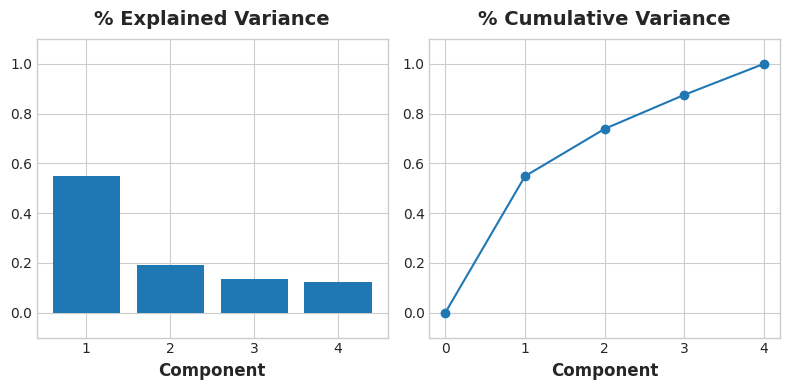

In [33]:
plot_variance(
    train[["GarageArea","YearRemodAdd","TotalBsmtSF","GrLivArea"]]
)

## 5.2 Loadings

In [34]:
pca, X_pca, loadings = apply_pca(
    train[["GarageArea","YearRemodAdd","TotalBsmtSF","GrLivArea"]]
)
loadings

,PC1,PC2,PC3,PC4
GarageArea,0.542671,0.055849,0.172729,-0.820094
YearRemodAdd,0.418537,-0.883023,-0.052628,0.205735
TotalBsmtSF,0.518308,0.324224,0.617357,0.495082
GrLivArea,0.511558,0.334709,-0.765680,0.200032


## 5.3 Outlier Detection

In [35]:
def check_outliers(X_pca, component = "PC1"):
    idx = X_pca[component].sort_values(ascending=False).index
    return train.loc[idx, ["SalePrice", "Neighborhood", "SaleCondition"] + features].head(10)

In [36]:
check_outliers(X_pca)

,SalePrice,Neighborhood,SaleCondition,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1298,160000,Edwards,Partial,60,RL,313.0,63887,Pave,NaN,IR3,...,0,480,Gd,NaN,NaN,0,1,2008,New,Partial
523,184750,Edwards,Partial,60,RL,130.0,40094,Pave,NaN,IR1,...,0,0,NaN,NaN,NaN,0,10,2007,New,Partial
1182,745000,NoRidge,Abnorml,60,RL,160.0,15623,Pave,NaN,IR1,...,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml
691,755000,NoRidge,Normal,60,RL,104.0,21535,Pave,NaN,IR1,...,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal
496,430000,NoRidge,Normal,20,RL,NaN,12692,Pave,NaN,IR1,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
581,253293,NridgHt,Partial,20,RL,98.0,12704,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,8,2009,New,Partial
178,501837,StoneBr,Partial,20,RL,63.0,17423,Pave,NaN,IR1,...,0,0,NaN,NaN,NaN,0,7,2009,New,Partial
440,555000,NridgHt,Normal,20,RL,105.0,15431,Pave,NaN,Reg,...,170,0,NaN,NaN,NaN,0,4,2009,WD,Normal
1169,625000,NoRidge,Normal,60,RL,118.0,35760,Pave,NaN,IR1,...,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal
1373,466500,NoRidge,Normal,20,RL,NaN,11400,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,3,2007,WD,Normal


## 5.4 PCA Features

In [37]:
# Performs PCA on the whole dataframe
def pca_transform(X_train, X_valid, X_test = None, features = ["GarageArea","YearRemodAdd","TotalBsmtSF","GrLivArea"], n_components = 2):
    
    assert n_components <= len(features)
    
    X_train, X_valid, X_test = preprocessing(X_train, X_valid, X_test)
    
    # Normalize based on training data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train[features])
    X_valid_scaled = scaler.transform(X_valid[features])
    if X_test is not None: X_test_scaled = scaler.transform(X_test[features])
    
    # Create principal components
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X_scaled)
    X_valid_pca = pca.transform(X_valid_scaled)
    if X_test is not None: X_test_pca = pca.transform(X_test_scaled)
    
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    X_valid_pca = pd.DataFrame(X_valid_pca, columns=component_names)
    if X_test is not None: X_test_pca = pd.DataFrame(X_test_pca, columns=component_names)
    
    if X_test is not None: 
        return X_train.join(X_pca), X_valid.join(X_valid_pca), X_test.join(X_test_pca)

    return X_train.join(X_pca), X_valid.join(X_valid_pca), X_test

In [38]:
# PCA components
score = score_xgboost(processing = pca_transform)

# Save scores
benchmarks['feature'].append('PCA_Comps')
benchmarks['score'].append(score)

Fold 0 MAE: 20047.75589 in 0.87s.
Fold 1 MAE: 13841.51966 in 4.95s.
Fold 2 MAE: 15696.08242 in 2.12s.
Fold 3 MAE: 16044.09842 in 2.14s.
Fold 4 MAE: 15439.89594 in 3.94s.
Fold 5 MAE: 18030.39338 in 4.1s.
Fold 6 MAE: 16986.44602 in 3.97s.
Fold 7 MAE: 13561.73431 in 3.03s.
Fold 8 MAE: 14589.14647 in 2.16s.
Fold 9 MAE: 17668.75888 in 1.71s.
Fold 10 MAE: 17624.05837 in 1.03s.
Fold 11 MAE: 13767.09772 in 3.96s.


## PCA Inspired Features

In [39]:
def pca_inspired(X_train, X_valid, X_test = None):
    
    X_train, X_valid, X_test = preprocessing(X_train, X_valid, X_test)
    
    X_train["Feature1"] = X_train.GrLivArea + X_train.TotalBsmtSF
    X_train["Feature2"] = X_train.YearRemodAdd * X_train.TotalBsmtSF
    X_valid["Feature1"] = X_valid.GrLivArea + X_valid.TotalBsmtSF
    X_valid["Feature2"] = X_valid.YearRemodAdd * X_valid.TotalBsmtSF
    if X_test is not None:
        X_test["Feature1"] = X_test.GrLivArea + X_test.TotalBsmtSF
        X_test["Feature2"] = X_test.YearRemodAdd * X_test.TotalBsmtSF
    
    return X_train, X_valid, X_test

In [40]:
# PCA inspired features
score = score_xgboost(processing = pca_inspired)

# Save scores
benchmarks['feature'].append('PCA_Inspired')
benchmarks['score'].append(score)

Fold 0 MAE: 18259.21126 in 0.89s.
Fold 1 MAE: 12196.40093 in 2.63s.
Fold 2 MAE: 16446.8823 in 1.95s.
Fold 3 MAE: 14636.7297 in 2.18s.
Fold 4 MAE: 15595.89203 in 2.39s.
Fold 5 MAE: 16366.95975 in 4.4s.
Fold 6 MAE: 16481.99609 in 2.77s.
Fold 7 MAE: 14240.33696 in 3.79s.
Fold 8 MAE: 16277.34553 in 3.74s.
Fold 9 MAE: 16647.59252 in 3.31s.
Fold 10 MAE: 15405.12907 in 3.71s.
Fold 11 MAE: 14345.87774 in 2.38s.


# Lesson 6: Target Encoding

We use the wrapper from the [bonus notebook](https://www.kaggle.com/ryanholbrook/feature-engineering-for-house-prices) to target encode a few categorical variables.

In [41]:
class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

## 6.1 Encode Neighborhood

We use `Neighborhood` to target encode since it is a high cardinality nominal feature which is likely very important for determining the target `SalePrice`.

In [42]:
def encode_neighborhood(X_train, X_valid, X_test = None):
    
    X_train, X_valid, X_test = preprocessing(X_train, X_valid, X_test)
    y_train = train['SalePrice'].iloc[X_train.index]
    
    encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    X1_train = encoder.fit_transform(X_train, y_train, cols=["Neighborhood"])
    X1_valid = encoder.transform(X_valid)
    if X_test is not None: X1_test = encoder.transform(X_test)
    
    if X_test is not None:
        return X_train.join(X1_train), X_valid.join(X1_valid), X_test.join(X1_test)

    return X_train.join(X1_train), X_valid.join(X1_valid), X_test

In [43]:
# Target encode neighborhood
score = score_xgboost(processing = encode_neighborhood)

# Save scores
benchmarks['feature'].append('Encode_Neighborhood')
benchmarks['score'].append(score)

Fold 0 MAE: 17574.08811 in 0.91s.
Fold 1 MAE: 13542.40964 in 3.56s.
Fold 2 MAE: 15944.44871 in 2.58s.
Fold 3 MAE: 15569.13403 in 2.52s.
Fold 4 MAE: 14598.93366 in 2.25s.
Fold 5 MAE: 16913.39453 in 3.64s.
Fold 6 MAE: 16478.60784 in 3.57s.
Fold 7 MAE: 13506.64351 in 1.97s.
Fold 8 MAE: 14612.85795 in 2.74s.
Fold 9 MAE: 16127.4722 in 1.56s.
Fold 10 MAE: 15563.10473 in 1.09s.
Fold 11 MAE: 14045.58833 in 3.04s.


## 10.2 Encode Subclass

The example in the notes uses `MSSubClass` for target encoding so we test it out here for sake of completeness.

In [44]:
def encode_subclass(X_train, X_valid, X_test = None):
    
    X_train, X_valid, X_test = preprocessing(X_train, X_valid, X_test)
    y_train = train['SalePrice'].iloc[X_train.index]
    
    encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    X1_train = encoder.fit_transform(X_train, y_train, cols=["MSSubClass"])
    X1_valid = encoder.transform(X_valid)
    if X_test is not None: X1_test = encoder.transform(X_test)
        
    if X_test is not None:
        return X_train.join(X1_train), X_valid.join(X1_valid), X_test.join(X1_test)

    return X_train.join(X1_train), X_valid.join(X1_valid), X_test

In [45]:
# Target encode neighborhood
score = score_xgboost(processing = encode_subclass)

# Save scores
benchmarks['feature'].append('Encode_Subclass')
benchmarks['score'].append(score)

Fold 0 MAE: 18432.90862 in 0.96s.
Fold 1 MAE: 13998.32588 in 3.64s.
Fold 2 MAE: 15924.8467 in 1.68s.
Fold 3 MAE: 16210.06404 in 3.54s.
Fold 4 MAE: 15523.41598 in 3.59s.
Fold 5 MAE: 17691.37801 in 3.51s.
Fold 6 MAE: 16190.81231 in 2.46s.
Fold 7 MAE: 13785.88595 in 1.58s.
Fold 8 MAE: 14382.76524 in 2.98s.
Fold 9 MAE: 17583.7735 in 1.85s.
Fold 10 MAE: 16182.09872 in 1.83s.
Fold 11 MAE: 13429.29607 in 2.34s.


# Determining Feature Engineering Strategy

In this section we compare all the above strategies versus the baseline and choose which we will use in our final model.

In [46]:
pd.DataFrame(benchmarks).sort_values('score', ascending = False)

,feature,score
8,Cluster_Dist,16114.384871
9,PCA_Comps,16108.082289
3,Interactions,15853.572220
7,Cluster_Labels,15843.717681
0,Baseline,15838.471986
5,MSZoning,15838.471986
12,Encode_Subclass,15777.964251
4,Count,15755.989377
1,Mutual_Info,15660.612942
10,PCA_Inspired,15575.029491


## Final Feature Engineering

In [47]:
def feature_engineering(X_train, X_valid, X_test = None):
    
    X_train, X_valid, X_test = preprocessing(X_train, X_valid, X_test)
    y_train = train['SalePrice'].iloc[X_train.index]
    
    # Cluster Labels
    features = ['LotArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF','GrLivArea']
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train[features])
    X_valid_scaled = scaler.transform(X_valid[features])
    if X_test is not None: 
        X_test_scaled = scaler.transform(X_test[features])
    kmeans = KMeans(n_clusters = 10, n_init = 10, random_state=0)
    X_train["Cluster"] = kmeans.fit_predict(X_scaled)
    X_valid["Cluster"] = kmeans.predict(X_valid_scaled)
    if X_test is not None: 
        X_test["Cluster"] = kmeans.predict(X_test_scaled)
    
    # Group Transformation
    X_train["MedNhbdLvArea"] = X_train.groupby("Neighborhood")["GrLivArea"].transform('median')
    mapping = {y:x for x,y in zip(X_train["MedNhbdLvArea"].values, X_train['Neighborhood'].values)}
    X_valid["MedNhbdLvArea"] = X_valid['Neighborhood'].map(mapping)
    if X_test is not None: 
        X_test["MedNhbdLvArea"] = X_test['Neighborhood'].map(mapping)
    
    # PCA Inspired
    X_train["Feature1"] = X_train.GrLivArea + X_train.TotalBsmtSF
    X_train["Feature2"] = X_train.YearRemodAdd * X_train.TotalBsmtSF
    X_valid["Feature1"] = X_valid.GrLivArea + X_valid.TotalBsmtSF
    X_valid["Feature2"] = X_valid.YearRemodAdd * X_valid.TotalBsmtSF
    if X_test is not None:
        X_test["Feature1"] = X_test.GrLivArea + X_test.TotalBsmtSF
        X_test["Feature2"] = X_test.YearRemodAdd * X_test.TotalBsmtSF
    
    # Transformations
    X_train = transformations(X_train)
    X_valid = transformations(X_valid)
    if X_test is not None: 
        X_test = transformations(X_test, test_data = True)
    
    # Target Encode Subclass
    encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    X1_train = encoder.fit_transform(X_train, y_train, cols=["MSSubClass"])
    X1_valid = encoder.transform(X_valid)
    if X_test is not None: 
        X1_test = encoder.transform(X_test)
        
    if X_test is not None:
        X_train, X_valid, X_test = X_train.join(X1_train), X_valid.join(X1_valid), X_test.join(X1_test)
    else:
        X_train, X_valid = X_train.join(X1_train), X_valid.join(X1_valid)
        
    # Target Encode Neighborhood
    encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    X2_train = encoder.fit_transform(X_train, y_train, cols=["Neighborhood"])
    X2_valid = encoder.transform(X_valid)
    if X_test is not None: 
        X2_test = encoder.transform(X_test)
        
    if X_test is not None:
        return X_train.join(X2_train), X_valid.join(X2_valid), X_test.join(X2_test)

    return X_train.join(X2_train), X_valid.join(X2_valid), X_test

In [48]:
score_xgboost(processing = feature_engineering)

Fold 0 MAE: 17711.62519 in 1.18s.
Fold 1 MAE: 12602.25423 in 2.38s.
Fold 2 MAE: 17217.45351 in 4.46s.
Fold 3 MAE: 14422.34682 in 3.14s.
Fold 4 MAE: 14221.63102 in 3.14s.
Fold 5 MAE: 16633.37468 in 2.88s.
Fold 6 MAE: 15896.54636 in 4.66s.
Fold 7 MAE: 14872.89069 in 2.73s.
Fold 8 MAE: 15546.9304 in 4.34s.
Fold 9 MAE: 16956.35905 in 1.87s.
Fold 10 MAE: 14702.58219 in 1.77s.
Fold 11 MAE: 15505.68172 in 3.06s.


15524.13965553801

# Hyperparameter Search

Now that we have established our preprocessing and feature engineering strategies we want to optimize our model parameters.

## Pruning

We use a pruner to skip unpromising trials (in the lower 50% of scores for that fold).

In [49]:
# Tweak Pruner settings
pruner = PercentilePruner(
    percentile = 33,
    n_startup_trials = 10,
    n_warmup_steps = 0,
    interval_steps = 1,
    n_min_trials = 10,
)

In [50]:
def parameter_search(trials):
    
    # Optuna objective function
    def objective(trial):
        
        model_params = dict( 
            # default 6
            max_depth = trial.suggest_int(
                "max_depth", 2, 12
            ), 
            # default 0.3
            learning_rate = trial.suggest_loguniform(
                "learning_rate", 0.01, 0.3
            ),
            # default 0
            gamma = trial.suggest_loguniform(
                "gamma", 1e-10, 100
            ), 
            # default 1
            min_child_weight = trial.suggest_loguniform(
                "min_child_weight", 1e-2, 1e2
            ),
            # default 1
            subsample = trial.suggest_discrete_uniform(
                "subsample", 0.2, 1.0, 0.01
            ),
            # default 1
            colsample_bytree = trial.suggest_discrete_uniform(
                "colsample_bytree",  0.2, 1.0, 0.01
            ),
            # default 1
            colsample_bylevel = trial.suggest_discrete_uniform(
                "colsample_bylevel",  0.2, 1.0, 0.01
            ),
            # default 1
            reg_lambda = trial.suggest_loguniform(
                "reg_lambda", 1e-10, 100
            ),
            # default 0
            reg_alpha = trial.suggest_loguniform(
                "reg_alpha", 1e-10, 100
            ),
        )
        
        return score_xgboost(
            xgb_model = XGBRegressor(
                random_state = RANDOM_SEED, 
                n_estimators = MAX_TREES,
                n_jobs = 4,
                **model_params
            ),
            processing = feature_engineering,
            trial = trial
        )
    
    
    optuna.logging.set_verbosity(optuna.logging.DEBUG)
    study = optuna.create_study(
        pruner = pruner,
        direction = "minimize"
    )
    # close to default parameters
    study.enqueue_trial({
        'max_depth': 6, 
        'learning_rate': 0.3, 
        'gamma': 1e-10,
        'min_child_weight': 1, 
        'subsample': 1, 
        'colsample_bytree': 1, 
        'colsample_bylevel': 1,
        'reg_lambda': 1,
        'reg_alpha': 1,
    })
    study.optimize(objective, n_trials=trials)
    return study

In [51]:
study = parameter_search(NUM_TRIALS)

[I 2022-01-07 04:26:38,071] A new study created in memory with name: no-name-9f2693fd-a70b-4fa9-8f35-07cd3658aff6
[D 2022-01-07 04:26:38,074] Trial 0 popped from the trial queue.


Fold 0 MAE: 17482.55923 in 0.82s.
Fold 1 MAE: 13412.27373 in 1.51s.
Fold 2 MAE: 17607.18231 in 1.42s.
Fold 3 MAE: 15405.7159 in 0.87s.
Fold 4 MAE: 15705.8076 in 1.14s.
Fold 5 MAE: 17715.16464 in 1.03s.
Fold 6 MAE: 17735.45742 in 1.62s.
Fold 7 MAE: 17080.10432 in 1.31s.
Fold 8 MAE: 16037.11942 in 0.76s.
Fold 9 MAE: 16363.31298 in 0.98s.
Fold 10 MAE: 15726.69273 in 1.48s.
Fold 11 MAE: 16598.14179 in 1.16s.


[I 2022-01-07 04:28:21,521] Trial 0 finished with value: 16405.79433842047 and parameters: {'max_depth': 6, 'learning_rate': 0.3, 'gamma': 1e-10, 'min_child_weight': 1, 'subsample': 1, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'reg_lambda': 1, 'reg_alpha': 1}. Best is trial 0 with value: 16405.79433842047.


Fold 0 MAE: 18641.59983 in 0.34s.
Fold 1 MAE: 12173.07307 in 0.53s.
Fold 2 MAE: 16604.42745 in 1.02s.
Fold 3 MAE: 14860.91281 in 0.44s.
Fold 4 MAE: 14809.34337 in 0.58s.
Fold 5 MAE: 16311.05507 in 0.6s.
Fold 6 MAE: 16450.20108 in 1.1s.
Fold 7 MAE: 13182.78714 in 0.88s.
Fold 8 MAE: 15580.18614 in 0.62s.
Fold 9 MAE: 14697.68944 in 0.5s.
Fold 10 MAE: 16370.11331 in 0.7s.
Fold 11 MAE: 15289.1354 in 0.84s.


[I 2022-01-07 04:29:57,215] Trial 1 finished with value: 15414.21034200548 and parameters: {'max_depth': 4, 'learning_rate': 0.18935962440187712, 'gamma': 9.914817223127314e-05, 'min_child_weight': 1.4620563570259766, 'subsample': 1.0, 'colsample_bytree': 0.5800000000000001, 'colsample_bylevel': 0.66, 'reg_lambda': 3.561682833286995e-07, 'reg_alpha': 1.0127610546661957e-10}. Best is trial 1 with value: 15414.21034200548.


Fold 0 MAE: 18685.25096 in 2.22s.
Fold 1 MAE: 11426.83968 in 6.04s.
Fold 2 MAE: 14245.40964 in 5.02s.
Fold 3 MAE: 14207.9822 in 8.69s.
Fold 4 MAE: 14563.89671 in 15.18s.
Fold 5 MAE: 15251.40378 in 19.76s.
Fold 6 MAE: 16609.82134 in 5.36s.
Fold 7 MAE: 12919.09951 in 8.8s.
Fold 8 MAE: 14558.16129 in 14.87s.
Fold 9 MAE: 15950.43082 in 3.38s.
Fold 10 MAE: 14158.8012 in 2.3s.
Fold 11 MAE: 14445.0081 in 7.74s.


[I 2022-01-07 04:33:02,489] Trial 2 finished with value: 14751.842103078925 and parameters: {'max_depth': 12, 'learning_rate': 0.022423420122419876, 'gamma': 3.1061273624249436e-10, 'min_child_weight': 0.011262659025567603, 'subsample': 0.5700000000000001, 'colsample_bytree': 0.42000000000000004, 'colsample_bylevel': 1.0, 'reg_lambda': 6.240721795061982, 'reg_alpha': 4.03430708073694}. Best is trial 2 with value: 14751.842103078925.


Fold 0 MAE: 19169.29816 in 1.29s.
Fold 1 MAE: 11445.40158 in 1.86s.
Fold 2 MAE: 14335.48591 in 1.91s.
Fold 3 MAE: 14677.56785 in 1.8s.
Fold 4 MAE: 14128.64696 in 1.55s.
Fold 5 MAE: 15854.23988 in 1.72s.
Fold 6 MAE: 14589.56224 in 1.8s.
Fold 7 MAE: 13674.15727 in 1.92s.
Fold 8 MAE: 15502.27815 in 1.87s.
Fold 9 MAE: 14939.54545 in 1.66s.
Fold 10 MAE: 16848.60789 in 1.34s.
Fold 11 MAE: 14172.22485 in 2.11s.


[I 2022-01-07 04:34:50,418] Trial 3 finished with value: 14944.751350177154 and parameters: {'max_depth': 12, 'learning_rate': 0.026517752276865304, 'gamma': 6.8905071622980444e-09, 'min_child_weight': 5.230212239316687, 'subsample': 0.22, 'colsample_bytree': 0.62, 'colsample_bylevel': 0.8500000000000001, 'reg_lambda': 7.324297722017727e-05, 'reg_alpha': 4.2256322400223905e-05}. Best is trial 2 with value: 14751.842103078925.


Fold 0 MAE: 20890.38781 in 0.5s.
Fold 1 MAE: 13450.45799 in 0.56s.
Fold 2 MAE: 18318.74328 in 0.49s.
Fold 3 MAE: 17307.33927 in 0.7s.
Fold 4 MAE: 17707.29742 in 0.5s.
Fold 5 MAE: 21150.89517 in 0.82s.
Fold 6 MAE: 18829.33831 in 0.88s.
Fold 7 MAE: 17501.16233 in 0.6s.
Fold 8 MAE: 17823.4529 in 1.34s.
Fold 9 MAE: 15751.80992 in 0.53s.
Fold 10 MAE: 19127.13017 in 0.3s.
Fold 11 MAE: 16669.13146 in 0.61s.


[I 2022-01-07 04:36:25,086] Trial 4 finished with value: 17877.262167691788 and parameters: {'max_depth': 9, 'learning_rate': 0.2679087323112949, 'gamma': 3.564688304520466e-06, 'min_child_weight': 74.02779025672329, 'subsample': 0.75, 'colsample_bytree': 0.49, 'colsample_bylevel': 0.2, 'reg_lambda': 6.788600227748845e-06, 'reg_alpha': 8.693957492620925e-09}. Best is trial 2 with value: 14751.842103078925.


In [52]:
print("Best Parameters (Average):", study.best_params)

Best Parameters (Average): {'max_depth': 12, 'learning_rate': 0.022423420122419876, 'gamma': 3.1061273624249436e-10, 'min_child_weight': 0.011262659025567603, 'subsample': 0.5700000000000001, 'colsample_bytree': 0.42000000000000004, 'colsample_bylevel': 1.0, 'reg_lambda': 6.240721795061982, 'reg_alpha': 4.03430708073694}


In [53]:
plot_parallel_coordinate(study)

# Generate Submission

In [54]:
def make_submission(model_params):
    
    # Features
    features = [x for x in train.columns if x not in ['Id','SalePrice']]
    X_temp = train[features].copy()
    y_temp = train['SalePrice'].copy()
    
    # Data structure for storing scores and times
    test_preds = np.zeros((test.shape[0],))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    
    # Stratified k-fold cross-validation
    kfold = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(kfold.split(X_temp, y_bins)):
        
        # Training and Validation Sets
        X_train, X_valid = X_temp.iloc[train_idx], X_temp.iloc[valid_idx]
        y_train, y_valid = y_temp.iloc[train_idx], y_temp.iloc[valid_idx]
        X_test = test[features].copy()
        
        # Preprocessing
        X_train, X_valid, X_test = feature_engineering(X_train, X_valid, X_test)
        
        # Create model
        start = time.time()
        model = XGBRegressor(
            random_state = RANDOM_SEED, 
            n_estimators = MAX_TREES,
            n_jobs = 4,
            **model_params
        )
        model.fit(
            X_train, y_train, 
            early_stopping_rounds=EARLY_STOP,
            eval_set=[(X_valid, y_valid)], 
            verbose=False
        )
        
        # validation predictions
        valid_preds = np.ravel(model.predict(X_valid))
        test_preds += model.predict(X_test) / NUM_FOLDS
        scores[fold] = mean_absolute_error(y_valid, valid_preds)
        end = time.time()
        print(f'Fold {fold} MAE: {round(scores[fold], 5)} in {round(end-start,2)}s.')
        time.sleep(0.5)

    output = pd.DataFrame({'Id': test.Id,'SalePrice': test_preds})
    output.to_csv('new_submission.csv', index=False)

In [55]:
# Make final submission
make_submission(study.best_params)

Fold 0 MAE: 18685.25096 in 2.08s.
Fold 1 MAE: 11426.83968 in 5.83s.
Fold 2 MAE: 14245.40964 in 4.71s.
Fold 3 MAE: 14207.9822 in 8.72s.
Fold 4 MAE: 14563.89671 in 15.97s.
Fold 5 MAE: 15251.40378 in 19.49s.
Fold 6 MAE: 16609.82134 in 5.33s.
Fold 7 MAE: 12919.09951 in 8.83s.
Fold 8 MAE: 14558.16129 in 14.87s.
Fold 9 MAE: 15950.43082 in 3.33s.
Fold 10 MAE: 14158.8012 in 2.14s.
Fold 11 MAE: 14445.0081 in 7.45s.


Thanks for reading, I hope you found this useful!